In [2]:
cd ..

/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode


In [3]:
pwd

'/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode'

In [4]:
import os, sys
from glob import glob
import math
from pprint import pprint
import torch

import pygarment as pyg
import numpy as np
import matplotlib.pyplot as plt
import json
import svgpathtools
from svgpathtools import Path, Line
from matplotlib.colors import CenteredNorm
import time

import plotly.graph_objects as go
import trimesh
import pickle
from PIL import Image
import random
import cv2

def visualize_mesh_plotly(mesh_path):
    # Load the mesh using trimesh
    mesh = trimesh.load(mesh_path)
    
    # Create the 3D scatter plot for vertices
    fig = go.Figure(data=[
        go.Mesh3d(
            x=mesh.vertices[:, 0],
            y=mesh.vertices[:, 1],
            z=mesh.vertices[:, 2],
            i=mesh.faces[:, 0],
            j=mesh.faces[:, 1],
            k=mesh.faces[:, 2],
            opacity=0.8,
            color='lightgray'
        )
    ])
    
    # Update the layout
    fig.update_layout(
        scene=dict(
            aspectmode='data'  # Preserve aspect ratio
        ),
        width=800,
        height=800,
        showlegend=False
    )
    
    # Show the plot
    fig.show()


def plot_panel_info(
    ax, panel_name, panel_svg_path_dict, stitch_dict,
    N_SAMPLES: int = 100,
):
    path = panel_svg_path_dict[panel_name][0]
    
    # boundary_points = np.array([path.point(t) for t in np.linspace(0, 1, N_SAMPLES)])
    # boundary_points = np.array([boundary_points.real, boundary_points.imag]).T
        
    # ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'b-')
    ax.set_title(panel_name)
    ax.axis('equal')
    ax.grid(True)

    # Create a color map for different edges
    colors = plt.cm.rainbow(np.linspace(0, 1, len(path)))

    for edge_idx, segment in enumerate(path):
        
        segment_points = np.array([
            [segment.point(t).real, segment.point(t).imag]
            for t in np.linspace(0, 1, N_SAMPLES)
        ])
        
        ax.plot(
            segment_points[:, 0],
            segment_points[:, 1] * -1,
            '-', color=colors[edge_idx]
        )
        
        segment_center = segment.point(0.5)
        segment_center = np.array([segment_center.real, segment_center.imag])
    
        has_stitch = False
    
        for stitch_idx, stitch_edges in stitch_dict.items():
            # print(stitch_idx, stitch_edges)
            for edge_info in stitch_edges:
                if edge_info['edge'] == edge_idx and edge_info['panel'] == panel_name:
                    has_stitch = True
                    ax.text(
                        segment_center[0],
                        -segment_center[1],
                        f"{stitch_idx}\n{edge_info['edge']}",
                        ha='center', va='center'
                    )

        if not has_stitch:
            ax.text(
                segment_center[0],
                -segment_center[1],
                f"no stitch,\n{edge_idx}",
                ha='center', va='center'
            )
            
# DATA_POINT_PATH  = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_00YONAPXZE"
# GARMENT_ID = os.path.basename(DATA_POINT_PATH)
# PATTERN_PATH = os.path.join(DATA_POINT_PATH, f"{GARMENT_ID}_specification.json")

In [5]:
# pattern = pyg.pattern.wrappers.VisPattern(PATTERN_PATH)


# drawn_pattern_list = list(map(
#     lambda pannel_name : pattern._draw_a_panel(
#         pannel_name, apply_transform=False, fill=True
#     ),
#     pattern.panel_order()
# ))

In [6]:
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "back", "right", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}

In [7]:
import random

from itertools import permutations
list(permutations(render_props["sides"]))


[('front', 'back', 'right', 'left'),
 ('front', 'back', 'left', 'right'),
 ('front', 'right', 'back', 'left'),
 ('front', 'right', 'left', 'back'),
 ('front', 'left', 'back', 'right'),
 ('front', 'left', 'right', 'back'),
 ('back', 'front', 'right', 'left'),
 ('back', 'front', 'left', 'right'),
 ('back', 'right', 'front', 'left'),
 ('back', 'right', 'left', 'front'),
 ('back', 'left', 'front', 'right'),
 ('back', 'left', 'right', 'front'),
 ('right', 'front', 'back', 'left'),
 ('right', 'front', 'left', 'back'),
 ('right', 'back', 'front', 'left'),
 ('right', 'back', 'left', 'front'),
 ('right', 'left', 'front', 'back'),
 ('right', 'left', 'back', 'front'),
 ('left', 'front', 'back', 'right'),
 ('left', 'front', 'right', 'back'),
 ('left', 'back', 'front', 'right'),
 ('left', 'back', 'right', 'front'),
 ('left', 'right', 'front', 'back'),
 ('left', 'right', 'back', 'front')]

(1400, 900, 4)
(24, 4)


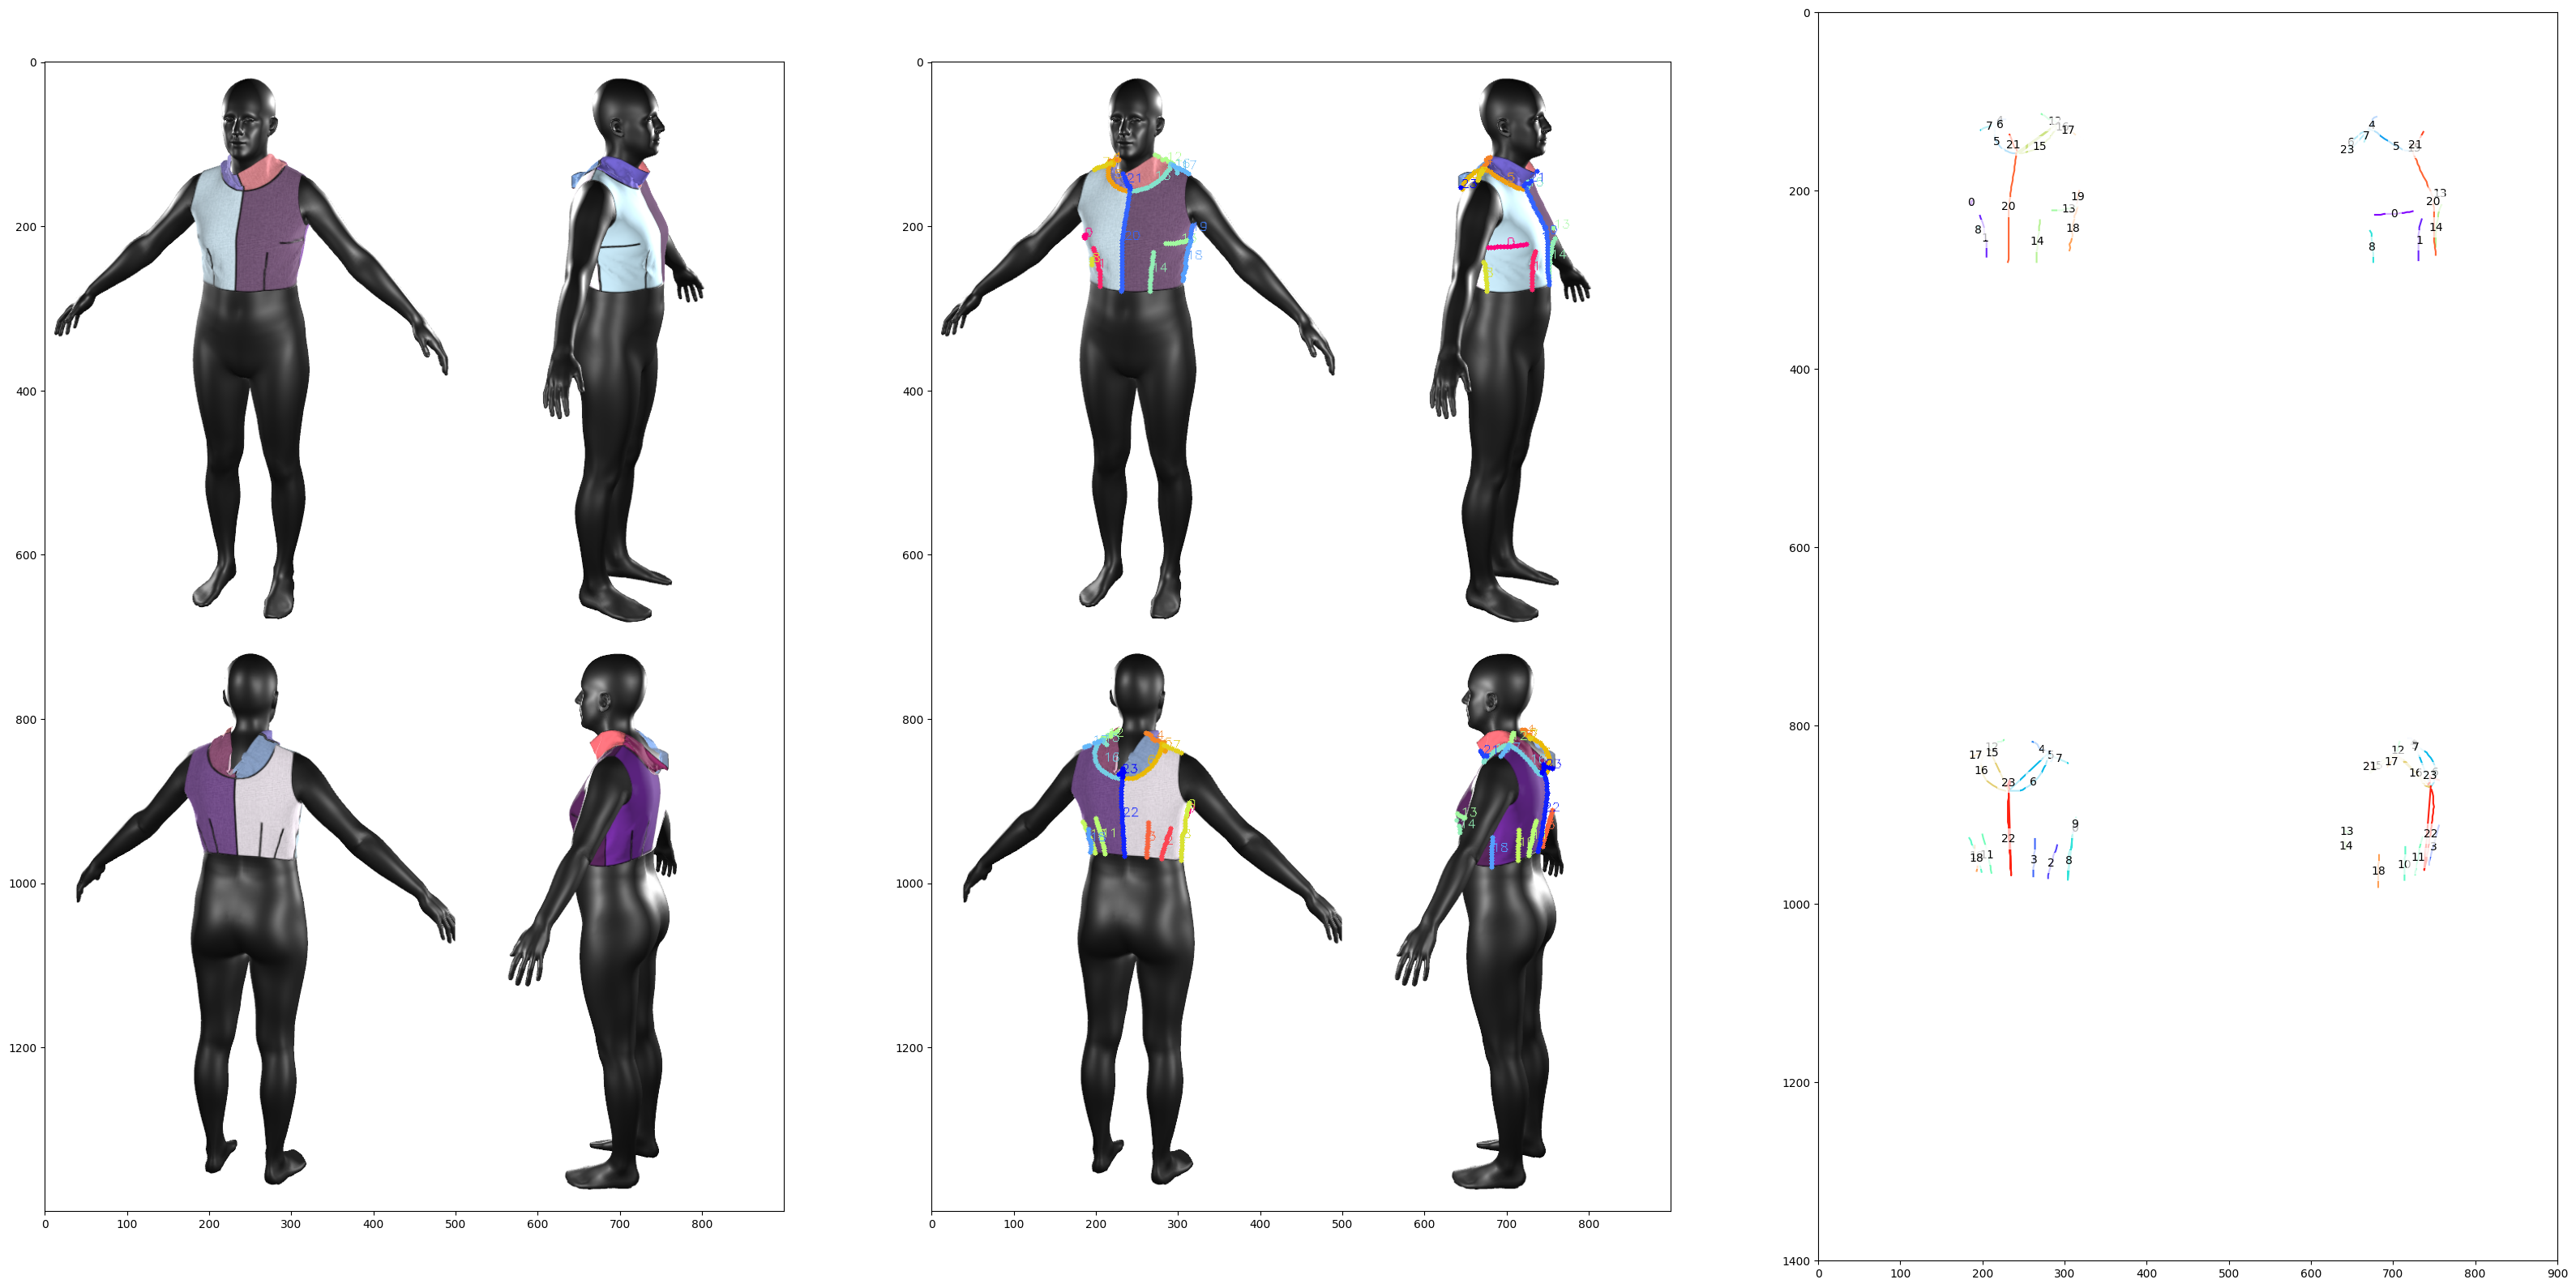

In [23]:
GARMENT_IDX = 10
# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))

IMG_WIDTH = 800
IMG_HEIGHT = 800

SIDE_LIST = ["front", "right", "back", "left"]
render_props["sides"] = SIDE_LIST

X_MIN_LIST = [150, 200, 150, 200]
WIDTH_LIST = [500, 400, 500, 400]
# XMAX_LIST = [650, 600, 650, 600]
Y_MIN_LIST = [100, 100, 100, 100]
HEIGHT_LIST = [700, 700, 700, 700]
# YMAX_LIST = [800, 800, 800, 800]

X_OFFSET_LIST = [0, 500, 0, 500]
Y_OFFSET_LIST = [0, 0, 700, 700]


FIG_LEN = 5
NCOLS = len(render_props["sides"])
NROWS = 2

garment_path = garment_path_list[GARMENT_IDX]
garment_id = os.path.basename(garment_path)

SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

rendered_image_list = list(map(
    lambda x : Image.open(os.path.join(garment_path, f"{garment_id}_render_{x}.png")),
    render_props["sides"]
))

final_image = np.vstack([
    np.hstack([
        np.array(rendered_image_list[0])[Y_MIN_LIST[0]:Y_MIN_LIST[0] + HEIGHT_LIST[0], X_MIN_LIST[0]:X_MIN_LIST[0] + WIDTH_LIST[0]],
        np.array(rendered_image_list[1])[Y_MIN_LIST[1]:Y_MIN_LIST[1] + HEIGHT_LIST[1], X_MIN_LIST[1]:X_MIN_LIST[1] + WIDTH_LIST[1]]
    ]),
    np.hstack([
        np.array(rendered_image_list[2])[Y_MIN_LIST[2]:Y_MIN_LIST[2] + HEIGHT_LIST[2], X_MIN_LIST[2]:X_MIN_LIST[2] + WIDTH_LIST[2]], 
        np.array(rendered_image_list[3])[Y_MIN_LIST[3]:Y_MIN_LIST[3] + HEIGHT_LIST[3], X_MIN_LIST[3]:X_MIN_LIST[3] + WIDTH_LIST[3]]
    ])
])
# vis_image = np.ones_like(final_image, dtype=np.uint8) * 255
vis_image = final_image.copy()

print(final_image.shape)

VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH = os.path.join(
    garment_path, "visible_seam_vertex_position_dict.pkl"
)
visible_seam_vertices_dict = pickle.load(open(VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH, "rb"))

final_seam_vertices_dict = {}
final_seam_vertices_dict_1000_norm = {}

unique_stitch_indices = list(visible_seam_vertices_dict.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stitch_indices)))

print(colors.shape)

unique_color_list = (colors[:, [2, 1, 0, 3]] * 255).astype(np.uint8)  # [:, :3] removes alpha, [:, ::-1] converts RGB to BGR;

for side_idx, side in enumerate(render_props["sides"]):
    orig_width, orig_height = 800, 800
    
    bbox_width = WIDTH_LIST[side_idx]
    bbox_height = HEIGHT_LIST[side_idx]
    
    x_offset = X_OFFSET_LIST[side_idx]
    y_offset = Y_OFFSET_LIST[side_idx]
    
    x_min = X_MIN_LIST[side_idx]
    y_min = Y_MIN_LIST[side_idx]
    
    final_seam_vertices_dict[side] = {}
    final_seam_vertices_dict_1000_norm[side] = {}
    
    for stitch_idx, visible_info in visible_seam_vertices_dict.items():
        if visible_info[side] is not None and len(visible_info[side]) > 0:
    
            pixel_coords = visible_info[side] - np.array([x_min, y_min]) + np.array([x_offset, y_offset])
            
            final_seam_vertices_dict[side][stitch_idx] = pixel_coords
            final_seam_vertices_dict_1000_norm[side][stitch_idx] = np.around(
                pixel_coords / np.array([final_image.shape[1], final_image.shape[0]]) * 1000,
                decimals=0
            ).astype(np.int32)
            
            vis_image[
                pixel_coords[:, 1].astype(np.int32),
                pixel_coords[:, 0].astype(np.int32), :
            ] = unique_color_list[stitch_idx]
                    

            cv2.putText(
                vis_image,
                str(stitch_idx),
                org=pixel_coords.mean(axis=0).astype(np.int32),  # Offset text slightly from point
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=unique_color_list[stitch_idx].tolist(),
                thickness=1
            )
            
            # Draw circles and text for each point
            for point in pixel_coords:
                x, y = point.astype(np.int32)
                # Draw circle
                cv2.circle(
                    vis_image, 
                    center=(x, y),
                    radius=3,
                    color=unique_color_list[stitch_idx].tolist(),
                    thickness=-1  # Filled circle
                )



colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stitch_indices)))
color_dict = dict(zip(unique_stitch_indices, colors))

plt.figure(figsize=(40, 20))
plt.subplot(1, 3, 1)
plt.imshow(final_image)

plt.subplot(1, 3, 2)
plt.imshow(vis_image)

plt.subplot(1, 3, 3)

for side in render_props["sides"]:
    for stitch_idx, vertices in final_seam_vertices_dict[side].items():
        mid_point = vertices[len(vertices)//2]
        plt.text(
            mid_point[0], mid_point[1], str(stitch_idx), 
            ha='center', va='center', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        plt.plot(
            vertices[:, 0], vertices[:, 1], '-',
            color=color_dict[stitch_idx],
            label = f"{side}_{stitch_idx}",
        )
        plt.xlim(0, final_image.shape[1])
        plt.ylim(final_image.shape[0], 0)  # Reversed y-axis to tch image coordinates



plt.show()

# plt.figure(figsize=(FIG_LEN * NCOLS, FIG_LEN * NROWS))
# for i, (image, vis_image) in enumerate(zip(rendered_image_list, vis_image_list)):
#     plt.subplot(NROWS, NCOLS, i + 1)
#     plt.title(
#         f"{render_props['sides'][i]}"
#     )
#     plt.imshow(image)
    
#     plt.subplot(NROWS, NCOLS, i + 1 + NCOLS)
#     plt.imshow(vis_image)

# plt.show()

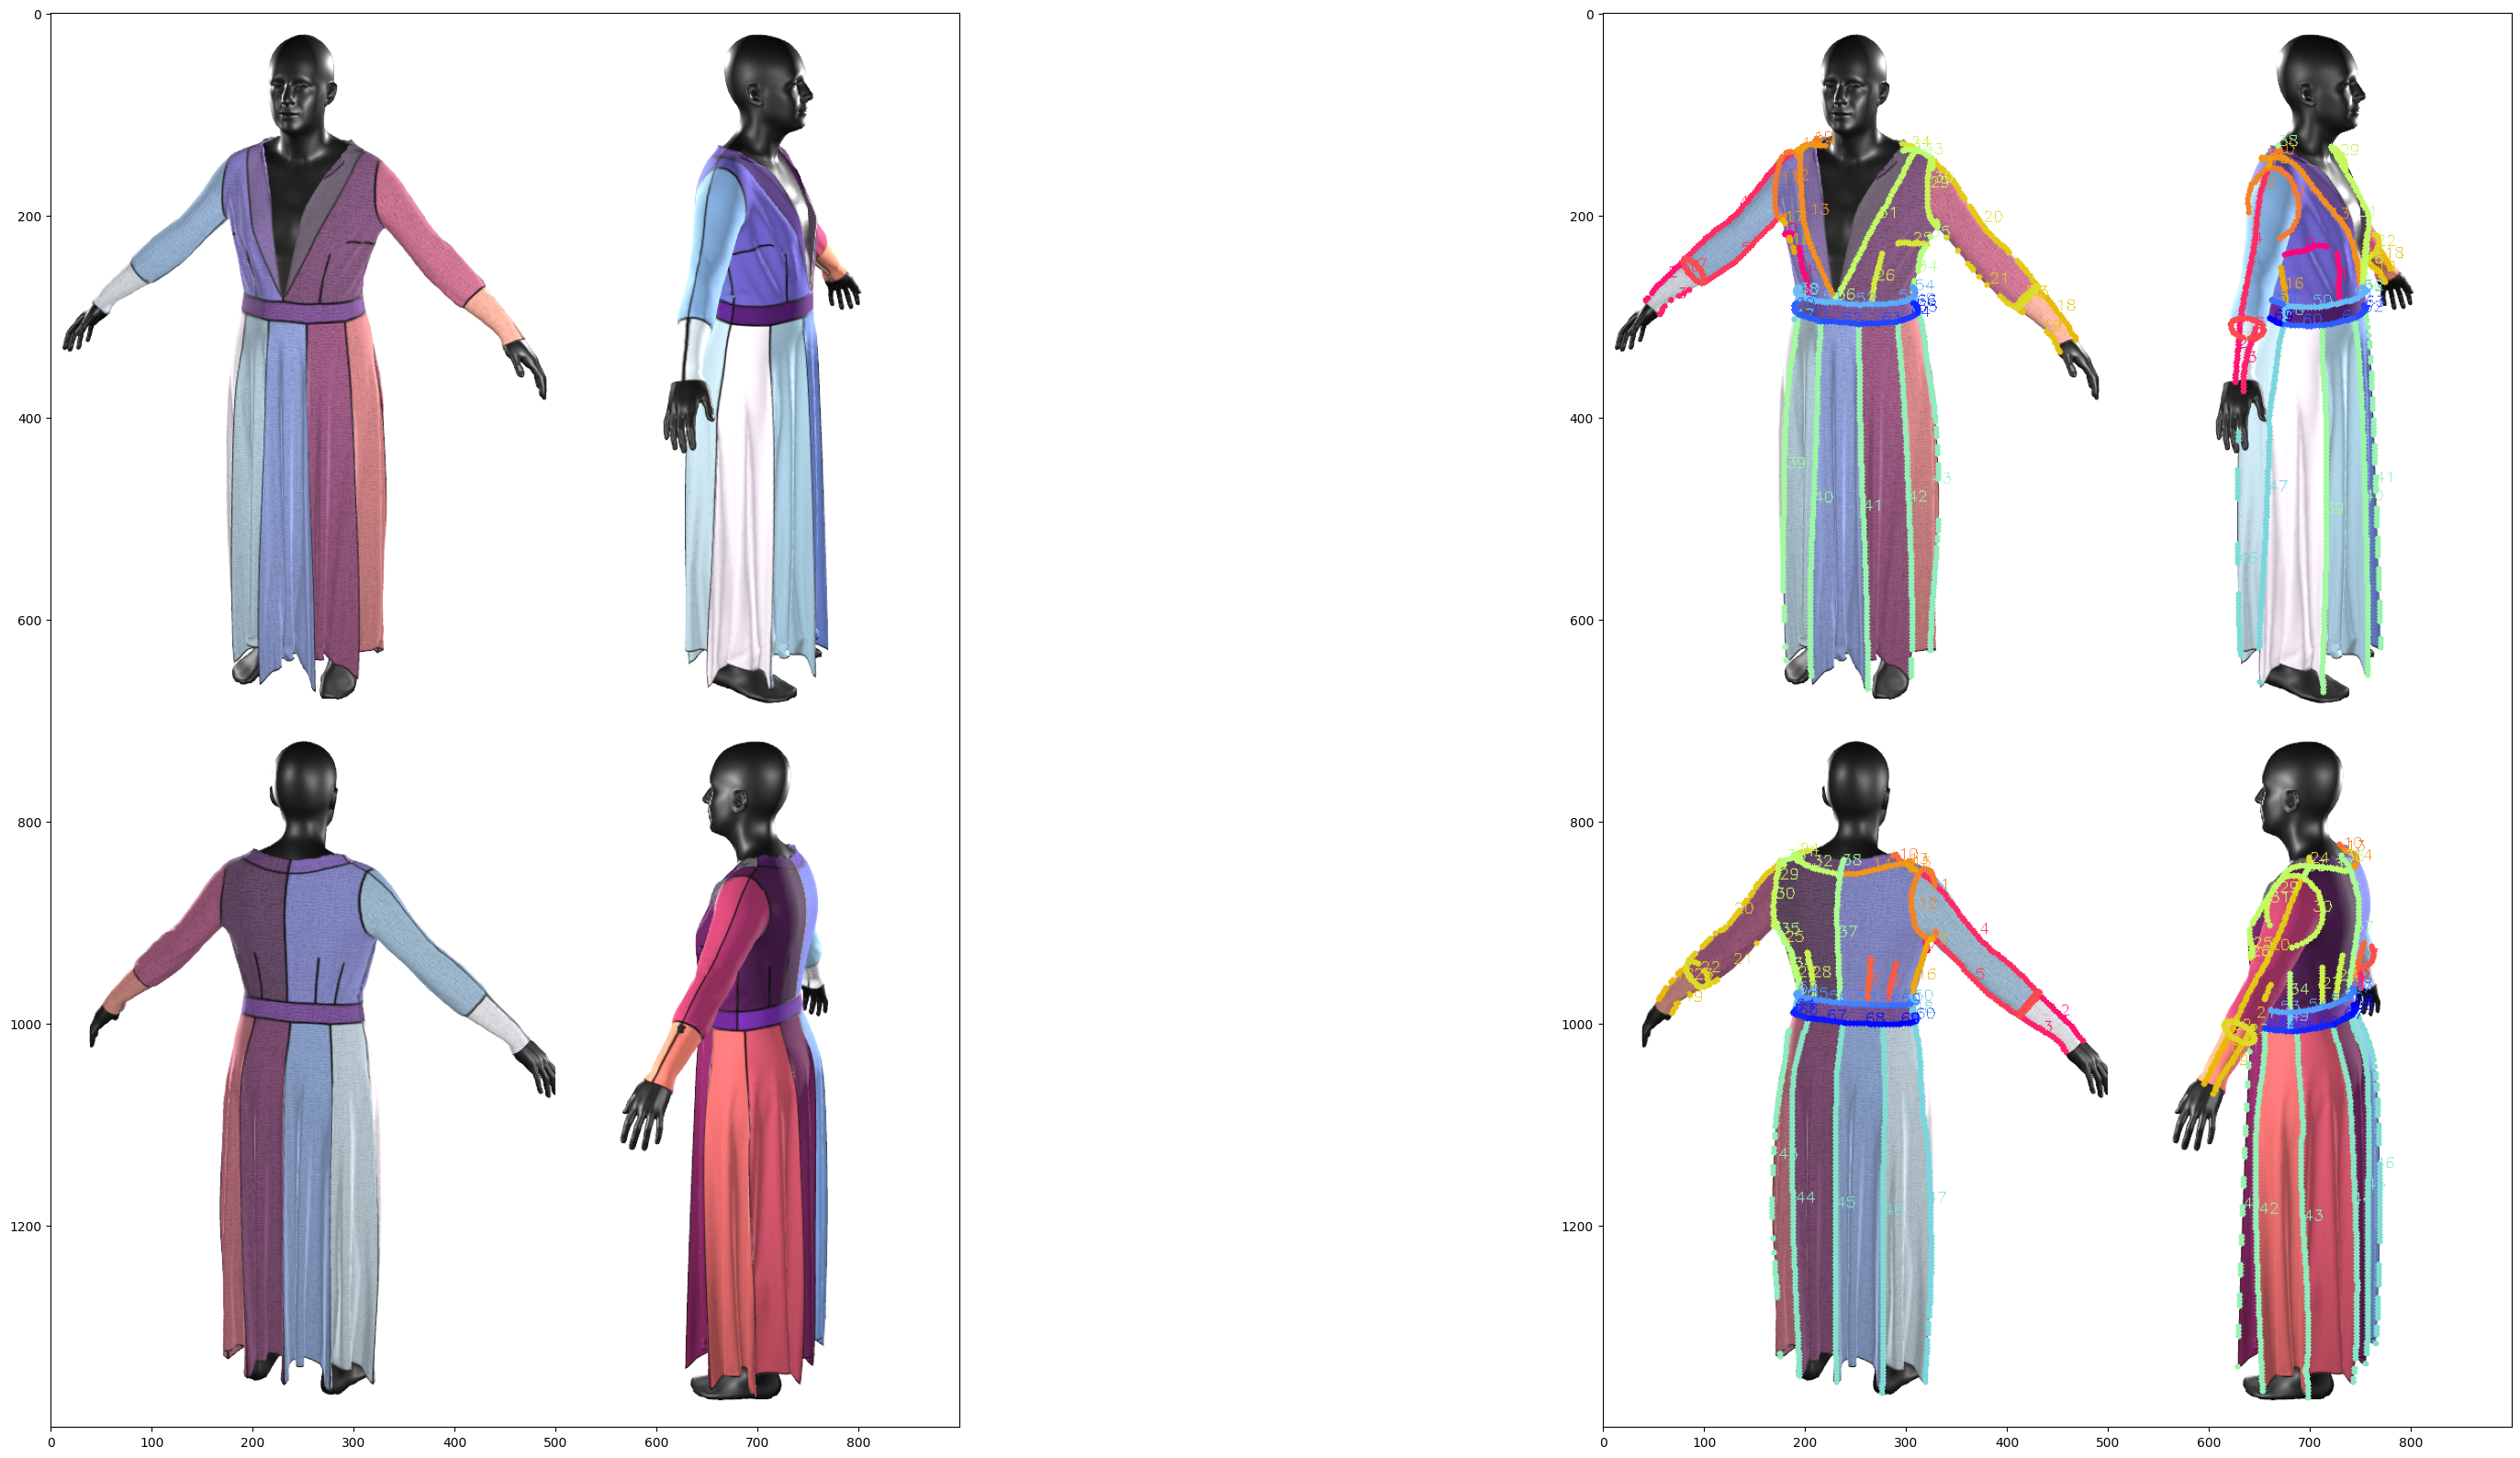

In [25]:

SIDE_LIST = ["front", "right", "back", "left"]
render_props["sides"] = SIDE_LIST

X_MIN_LIST = [150, 200, 150, 200]
WIDTH_LIST = [500, 400, 500, 400]
# XMAX_LIST = [650, 600, 650, 600]
Y_MIN_LIST = [100, 100, 100, 100]
HEIGHT_LIST = [700, 700, 700, 700]
# YMAX_LIST = [800, 800, 800, 800]

X_OFFSET_LIST = [0, 500, 0, 500]
Y_OFFSET_LIST = [0, 0, 700, 700]



BODY_TYPE = "default_body"

PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))

GARMENT_IDX = 0

garment_path = garment_path_list[GARMENT_IDX]
garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"
garment_id = os.path.basename(garment_path)


SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

rendered_image_list = list(map(
    lambda x : Image.open(os.path.join(garment_path, f"{garment_id}_render_{x}.png")),
    render_props["sides"]
))

final_image = np.vstack([
    np.hstack([
        np.array(rendered_image_list[0])[Y_MIN_LIST[0]:Y_MIN_LIST[0] + HEIGHT_LIST[0], X_MIN_LIST[0]:X_MIN_LIST[0] + WIDTH_LIST[0]],
        np.array(rendered_image_list[1])[Y_MIN_LIST[1]:Y_MIN_LIST[1] + HEIGHT_LIST[1], X_MIN_LIST[1]:X_MIN_LIST[1] + WIDTH_LIST[1]]
    ]),
    np.hstack([
        np.array(rendered_image_list[2])[Y_MIN_LIST[2]:Y_MIN_LIST[2] + HEIGHT_LIST[2], X_MIN_LIST[2]:X_MIN_LIST[2] + WIDTH_LIST[2]], 
        np.array(rendered_image_list[3])[Y_MIN_LIST[3]:Y_MIN_LIST[3] + HEIGHT_LIST[3], X_MIN_LIST[3]:X_MIN_LIST[3] + WIDTH_LIST[3]]
    ])
])
vis_image = final_image.copy()


VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH = os.path.join(
    garment_path, "visible_seam_vertex_position_dict.pkl"
)
visible_seam_vertices_dict = pickle.load(open(VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH, "rb"))

final_seam_vertices_dict = {}
final_seam_vertices_dict_1000_norm = {}

unique_stitch_indices = list(visible_seam_vertices_dict.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stitch_indices)))

unique_color_list = (colors[:, [2, 1, 0, 3]] * 255).astype(np.uint8)  # [:, :3] removes alpha, [:, ::-1] converts RGB to BGR;

for side_idx, side in enumerate(render_props["sides"]):
    orig_width, orig_height = 800, 800
    
    bbox_width = WIDTH_LIST[side_idx]
    bbox_height = HEIGHT_LIST[side_idx]
    
    x_offset = X_OFFSET_LIST[side_idx]
    y_offset = Y_OFFSET_LIST[side_idx]
    
    x_min = X_MIN_LIST[side_idx]
    y_min = Y_MIN_LIST[side_idx]
    
    final_seam_vertices_dict[side] = {}
    final_seam_vertices_dict_1000_norm[side] = {}
    
    for stitch_idx, visible_info in visible_seam_vertices_dict.items():
        if visible_info[side] is not None and len(visible_info[side]) > 0:
    
            pixel_coords = visible_info[side] - np.array([x_min, y_min]) + np.array([x_offset, y_offset])
            
            final_seam_vertices_dict[side][stitch_idx] = pixel_coords.astype(np.int32).tolist()
            final_seam_vertices_dict_1000_norm[side][stitch_idx] = np.around(
                pixel_coords / np.array([final_image.shape[1], final_image.shape[0]]) * 1000,
                decimals=0
            ).astype(np.int32).tolist()
            
            cv2.putText(
                vis_image,
                str(stitch_idx),
                org=pixel_coords.mean(axis=0).astype(np.int32),  # Offset text slightly from point
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=unique_color_list[stitch_idx].tolist(),
                thickness=1
            )
            
            # Draw circles and text for each point
            for point in pixel_coords:
                x, y = point
                # Draw circle
                cv2.circle(
                    vis_image, 
                    center=(x, y),
                    radius=3,
                    color=unique_color_list[stitch_idx].tolist(),
                    thickness=-1  # Filled circle
                )


plt.figure(figsize=(40, 20))
plt.subplot(1, 2, 1)
plt.imshow(final_image)

plt.subplot(1, 2, 2)
plt.imshow(vis_image)

plt.show()